## Загрузка библиотек и данных

In [6]:
import pandas as pd
import zipfile
import os
import time
import re
import nltk
import numpy as np
import scipy.sparse


In [7]:
# nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize # плохо обработались слова
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,  TfidfTransformer
# матрицы
from scipy.sparse import hstack



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
# моделька
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score, RepeatedStratifiedKFold,GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

In [9]:
!pip install pysrt
import pysrt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pysrt: filename=pysrt-1.1.2-py3-none-any.whl size=13443 sha256=40d95fdc3ccb12c779f5d6b9d8f77aacedc75a50dfc4c632ad0877160fd6cd58
  Stored in directory: /root/.cache/pip/wheels/30/7f/e8/55de9a9b07302d9e7fe47c27910e3bea0c48536153e74bd7e6
Successfully built pysrt


In [10]:
from google.colab import drive
from PIL import Image

In [11]:
!pip install pypdf
from pypdf import PdfReader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.3/270.3 kB 4.9 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')

### Создание дф

In [ ]:
# чтобы разгрузить код я буду путь к файлам сохранять в эту переменную
PATH = None

In [ ]:
# создаем датафрейм
PATH = '/content/drive/MyDrive/Masterskaya_2/English_scores.zip (Unzipped Files)/movies_labels.xlsx'
data = pd.read_excel(PATH)
data.head()

In [ ]:
# приведем названия столбцов к каноническому виду
data.columns = ['id', 'movie', 'level']
data.head()

In [ ]:
data.shape[0]

In [ ]:
# читаем файл с субтитрами
PATH = '/content/drive/MyDrive/Masterskaya_2/English_scores.zip (Unzipped Files)/Subtitles_all/Subtitles/10_Cloverfield_lane(2016).srt'
subs = pysrt.open(PATH)


In [ ]:
# я посмотрела как будут выглядеть субтитры
subtitle_texts = [subtitle.text for subtitle in subs]
subtitle_texts[:10]

Для того, чтобы получить субтитры в удобноваримом формате, мы пройдемся циклом по всему содержимому папки Subtitles, которая содержит папки с названиями фильмов. Для этого используем модуль os, который позволяет работать с файлами и директориями.

In [ ]:
PATH = '/content/drive/MyDrive/Masterskaya_2/English_scores.zip (Unzipped Files)/Subtitles_all/'

In [ ]:
PATH = '/content/drive/MyDrive/Masterskaya_2/English_scores.zip (Unzipped Files)/Subtitles_all/'

def get_subs():
    subtitles = []
    movie = []

    # Получаем все папки и файлы в указанной папке
    film_list = os.listdir(PATH)

    for folder in film_list:
        for film in os.listdir(os.path.join(PATH, folder)):
            # достаем названия
            last_dot = film.rfind('.')
            movie.append(film[:last_dot])

            # субтитры
            # собираем название путь
            file_to_read = os.path.join(PATH, folder, film)  # Исправленный путь к файлу
            # расшифровываем
            try:
                encoded_film = pysrt.open(file_to_read, encoding='iso-8859-1')
            except:
                encoded_film = pysrt.open(file_to_read, encoding='UTF-8')

            # трансформируем в текст
            subs_text = [film.text for film in encoded_film]
            subtitles.append(subs_text)

    return pd.DataFrame({'subs': subtitles, 'movie': movie})


Обращаем внимание, что имеются строки в которых точка используется как разделитель, это важно, так как нам нужно сохранить названия фильмов без расширения .srt

---

Делить будем так:
- находим индекс где стоит **последняя** точка
- добавляем строку до этого индекса

In [ ]:
subs_df = get_subs()
subs_df.head()

In [ ]:
subs_df.shape[0]

Теперь можно обработать названия фильмов, чтобы добавить субтитры к фильмам.
Обрабатывать буду следующими шагами:
- все слова к строчному регистру
- в качестве разделителя только знак нижнего подчеркивания "_"
- удалю все пробелы, знаки между словами, оставлю только цифры.

In [ ]:
data.head()

In [ ]:
def transform_values(df):
    # заменяем пробелы на underscore
    df = df.applymap(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)

    # заменяем дефис на underscore
    df = df.applymap(lambda x: x.replace('-', '_') if isinstance(x, str) else x)

    # добавляем underscore между словом и цислом
    df = df.applymap(lambda x: '_'.join(part for part in x.split() if not part.isdigit()) if isinstance(x, str) else x)
    # приводим к строчному регистру
    df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

    return df


In [ ]:
# почистим названия фильмов в дата
data = transform_values(data)
data.head()

In [ ]:
subs_df = transform_values(subs_df)
subs_df.head()

In [ ]:
subs_df['movie'] = transform_values(subs_df[['movie']])
subs_df['movie'].head()

In [ ]:
subs_df.head()

Сделаю тип объединения outer так как могут удалиться дубликаты, а я хочу сохранить все наблюдения и отдельно обработать дубликаты чтобы избежать ошибок.

In [ ]:
data = pd.merge (subs_df,data,
                 on = 'movie',
                 how = 'outer',
                 indicator = True)
data.head()

In [ ]:
data['_merge'].value_counts()

видим что у нас остались 49 фильмов только из датафрейма subs_df и 8 только из data.
очевидно, что для 49 фильмов у нас нет разметки по уровню и для 8 нет субтитров.

In [ ]:
data.loc[(data['_merge']=='left_only') | (data['_merge']=='right_only')]


reader = PdfReader('/content/drive/MyDrive/Masterskaya_2/Oxford_CEFR_level/American_Oxford_3000_by_CEFR_level.pdf')
number_of_pages = len(reader.pages)
page = reader.pages[0]
text = page.extract_text

In [ ]:
os.listdir('/content/drive/MyDrive/Masterskaya_2/Oxford_CEFR_level')

нужно либо маску разделитель уровней прописать либо предварительно вручную разграничить по уровням, потому что пока непонятно как работать с этим форматом text

## Предобработка и анализ

In [ ]:
data.dtypes

### Пропуски

In [ ]:
data.shape[0]

In [ ]:
data = data.dropna()
data = data.reset_index (drop=True)
data.isna().sum()

In [ ]:
data.shape[0]

### Дупликаты

In [ ]:
data['movie'].duplicated().sum()

In [ ]:
duplicates = data[data['movie'].duplicated()]
duplicates

Мы увидели только ошибочные дупликаты, удалять их не будем.

### Предобработка субтитров

In [ ]:
data.head()

- перевести значения в признаке subs в формат str
- нужно создать дополнительный столбец, чтобы превратить субтитры в кортеж из слов
- удалить символы кроме пробела и '', так как по длине фраз так же можно сделать предположение о сложности текста
- привести слова к первоначальной форме (ед число, настоящее время)/ лемматизация
- привести все слова к нижнему регистру
- удалить стоп-слова


In [ ]:
# заменим символы
data['subs'] = data['subs'].replace('\n', '\t', regex=True)
data['subs'][0][:5]

Видим, что остались символы \n без пробела, но на данном этапе не получилось их убрать не используя регулярные выражения.


---

data['sub'] содержит субтитры, которые представлены в формате список списков.

Каждый список (фильм) содержит список предложений, каждое предложение содержит список строк.

сначала нам нужно все эти строки (подсписки) соединить в одну строку, где каждый символ(разделен) пробелом.

Поэтому сначала мы получим слова из каждого подсписка в формате списка

  `[sub_words = []

    for sublist in data_column:

        for word in sublist.split():
        
            sub_words.append(word)]`.

Теперь нам нужно список собрать в строку, для этого объединим все элементы этого списка

```
' '.join([word for lists in word_list)
```

Теперь мы имеем субтитры записанные в строковом формате, которые можно почистить от знаков препинаний и создать кортеж вместо списков.

Текст должен быть обработан от символов, иначе получается слишком много слов за счет того что Hello! и Hello считаются разными словами.



In [ ]:
def extract_words(data_column):
    sub_words = []
    for sublist in data_column:
        for word in sublist.split():
            sub_words.append(word.lower())

    text = ' '.join(sub_words)
    pattern = r'[^\w\s\'\.]'
    text_cleaned = re.sub(pattern, '', text)

    return text_cleaned

In [ ]:
data['cleaned_up_subs'] = data['subs'].apply(extract_words)
data['cleaned_up_subs'][0]

In [ ]:
data['cleaned_up_subs'].apply(type)[0]

У нас получился новый признак data['used_words'] который содержит все слова, использованные в каждом фильме в формате str.

### Обработка библиотекой NLTK

In [ ]:
# Функция для токенизации, лемматизации и удаления стоп-слов
def preprocess_text(text):
    # Токенизация
    tokens = word_tokenize(text)

    # Лемматизация слов
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in lemmatized_words
                      if word.lower()not in stop_words]

    return filtered_words

In [ ]:
# Применение обработки к столбцу субтитров
data['preprocessed_subs'] = data['cleaned_up_subs'].apply(preprocess_text)
data['preprocessed_subs'].head()

Получили новый признак, содержащий обработанные субтитры, который можно будет использовать для получения векторов.

Вывод:
Мы создали датасет, содержащий следующие колонки:
 - subs, id, movie, level, _merge, unique_words.

Все данные относятся к типу object, числовые признаки отсутствуют.

В ходе соединения

Предобработка включала в себя:
- замена пропущенных значений заглушкой
Сделали предварительную очистку субтитров:
-


# Подготовка модели

### Баланс классов

In [ ]:
data['level'].value_counts(normalize = True)

Для начала нам достаточно только три основных уровня А, B, C.


In [ ]:
sorted(data['level'].unique())

In [ ]:
elementary = ['a2', 'a2/a2+', 'a2/a2+,_b1']
intermediate = ['b1', 'b1,_b2', 'b2']
advanced = ['c1']

In [ ]:
'a3' in elementary

In [ ]:
for level in data['level'].unique():
  if level in elementary:
    data.loc[data['level']==level, 'level'] = 'a'
  elif level in intermediate:
    data.loc[data['level']==level, 'level'] = 'b'
  else:
    data.loc[data['level']==level, 'level'] = 'c'

In [ ]:
data['level'].value_counts(normalize = True).to_frame()

Распределение классов весьма логичное:
больше всего фильмов для среднего уровня языка, а для продвинутого или начинающего уровня фильмов не так много.

На основании этого мы уже можем выбирать метрику, для нас критичнее будет предсказание класса b. Следовательно наша метрика должна отражать количество верно предсказанных классов a,c, таким образом нужно использовать:
- recall или f1 меру
- ROC AUC score.

### Признаки

In [ ]:
#Удалим лишние признаки
data.columns

In [ ]:
data = data.drop(['id', '_merge'], axis = 1)

Я создам 4 новых признака, которые основаны на кодировке субтитров разными библиотеками на столбцах 'cleaned_up_subs' и'preprocessed_subs':
- вектор созданный из словаря частотности слов встроенного Python модуля collections, bow_matrix (bag_of_words)
-вектор созданный трансформером TfidfTransformer, который позволяет определелить вес каждого слова.

#### BoW_matrix()

In [ ]:
data['preprocessed_subs'].apply(type).head()

In [ ]:
data['preprocessed_subs'] = data['preprocessed_subs'].apply(str)
data['preprocessed_subs'].apply(type).head()

In [ ]:
values = []
all_words = set()

for text in data['preprocessed_subs']:
    all_words.update(text.split())

for text in data['preprocessed_subs']:
    word_counts = Counter(text.split())
    vector = [word_counts[word] for word in all_words]
    values.append(vector)
# Преобразуем список values в массив numpy
preprocessed_matrix = np.array(values)

print(preprocessed_matrix.shape)

In [ ]:
values = []
all_words = set()

for text in data['cleaned_up_subs']:
    all_words.update(text.split())

for text in data['cleaned_up_subs']:
    word_counts = Counter(text.split())
    vector = [word_counts[word] for word in all_words]
    values.append(vector)
# Преобразуем список values в массив numpy
cleaned_up_matrix = np.array(values)

print(cleaned_up_matrix.shape)

#### tfidf

In [ ]:
count = CountVectorizer()
bag = count.fit_transform(np.array(list(data['preprocessed_subs'])))

In [ ]:
print (count.vocabulary_)

In [ ]:
print(type(bag))

In [ ]:
print(bag.toarray())

In [ ]:
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
tfidf_preprocessed_matrix = tfidf.fit_transform(bag)

In [ ]:
tfidf_preprocessed_matrix.shape

In [ ]:
# повторим шаги для признака cleaned_up
bag = count.fit_transform(np.array(list(data['cleaned_up_subs'])))
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
tfidf_cleaned_up_matrix = tfidf.fit_transform(bag)
tfidf_cleaned_up_matrix.shape

In [ ]:
data.head()

#### Cоздание датафрейма из матриц

В предыдущем разделе мы получили 4 матрицы, но просто присоединить их не получится из-за того что они разреженные.
Поэтому для того, чтобы получиться данные для обучения модели мы объединим все матрицы в один датасет используя библиотеку


```
scipy.sparse
```



In [ ]:
tfidf_features = hstack([tfidf_preprocessed_matrix, tfidf_cleaned_up_matrix])

In [ ]:
features_matrix = hstack([tfidf_cleaned_up_matrix, tfidf_preprocessed_matrix, preprocessed_matrix,
cleaned_up_matrix])

In [ ]:
df = pd.DataFrame.sparse.from_spmatrix(features_matrix)
df.head()

In [ ]:
df['level'] = data['level']
df.head()

### Деление выборок

Теперь мы можем разделить выборки на тренировочный и тестовый наборы

In [ ]:
train, test = train_test_split(df,
                               test_size=0.4,
                               random_state=42)
print (f'''
размер тренирвочной выборки {train.shape[0]}
размер тестовой выборки {test.shape[0]}
''')

In [ ]:
X = df.drop('level', axis = 1).columns
y = 'level'

In [ ]:
def encoding(train, test):
    # Отберем признаки для кодирования
    columns_to_encode = train.select_dtypes(include='object').columns
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(train[columns_to_encode])
    columns = encoder.get_feature_names_out(input_features=columns_to_encode)

    # Создаем датафрейм из перекодированных признаков
    train_encoded = pd.DataFrame(data=encoder.transform(train[columns_to_encode]).toarray(),
                                 columns=columns, index=train.index)
    train_encoded_df = pd.concat([train.drop(columns=columns_to_encode), train_encoded], axis=1)

    test_encoded = pd.DataFrame(data=encoder.transform(test[columns_to_encode]).toarray(),
                                columns=columns, index=test.index)
    test_encoded_df = pd.concat([test.drop(columns=columns_to_encode), test_encoded], axis=1)

    return train_encoded_df, test_encoded_df


# Выбор модели

In [ ]:
X_train = train[X]
y_train = train[y]
X_test = test[X]
y_test = test[y]

In [ ]:
%%time
model = LogisticRegression(multi_class='multinomial')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# параметры для кросвалидации
cv = RepeatedStratifiedKFold(n_splits=10,
                             n_repeats=3,
                             random_state=21
                             )

In [ ]:
%%time
scores = cross_val_score(model,
                         X_train,
                         y_train,
                         scoring='accuracy',
                         cv=cv,
                         n_jobs=-1)

In [ ]:
from numpy import mean
from numpy import std

In [ ]:
print('Accuracy: %.3f (%.3f)' , (mean(scores), std(scores)))

In [ ]:
classification_report_result = classification_report(y_test, y_pred)

In [ ]:
print(f'''accuracy: {accuracy:.4f}
Отчет о классификации:
{classification_report_result}''')

In [ ]:
# сетка для поиска параметров
param_grid = [
  {'solver':['lbfgs'], 'penalty':['l2'], 'C': [1, 10, 100, 1000], 'max_iter': [2000, 3000, 4000]},
  {'solver':['lbfgs'], 'penalty':['none']},
  {'solver':['newton-cg'], 'penalty':['l2'],'C':[1, 10, 100, 1000],'max_iter': [2000, 3000, 4000]},
  {'solver':[ 'sag'], 'penalty':['l2'], 'C': [1, 10, 100, 1000],'max_iter': [2000, 3000, 4000]},
  {'solver':[ 'sag'], 'penalty': [None],'max_iter': [2000, 3000, 4000]},
  {'solver':[ 'saga'], 'penalty':['l2'], 'C': [1, 10, 100, 1000],'max_iter': [2000, 3000, 4000]},
  {'solver':[ 'saga'], 'penalty': [None],'max_iter': [2000, 3000, 4000]}
 ]

тюнингуем модель используя gridsearch для настройки гиперпараметров

In [ ]:
%%time
# Выбираем лучшие гиперпараметры
grid_search = GridSearchCV(model,
                           param_grid=param_grid,
                           cv=cv)
# обучаем
grid_search.fit(X_train, y_train)

In [ ]:
# Получаем результаты работы модели
#results = grid_searchCV.results_
# Выводим значения метрики F1 при лучших гиперпараметрах
best_score = grid_search.best_score_

print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", best_score)


In [ ]:
grid_searchCV.mean_test_score

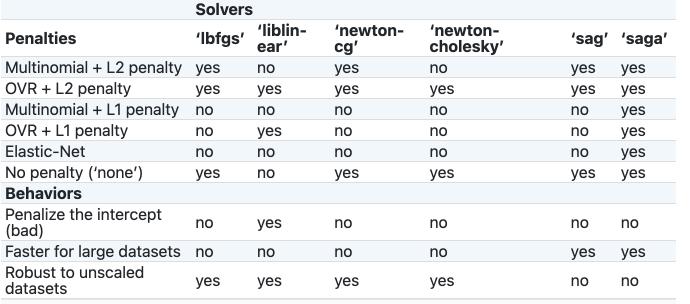